This notebook contains the scripts for processing the cycle time data generated by Assignment3_Q1.doe

In [1]:
#Import libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import pandas as pd
from scipy.stats import lognorm
from scipy.stats import norm
plt.rcParams.update({'font.size': 14})


In [2]:
#Function to compute running mean of data x, and average intervals of length N
def runningMean(x, N):
    y = np.zeros((len(x),))
    for ctr in range(len(x)):
         y[ctr] = np.sum(x[ctr:(ctr+N)])
    return y/N

------------------------

In [3]:

#Import data
data=pd.read_csv('Q1/CycleTimes.txt', sep=' ', header=None)
data=data.iloc[:, 0:3].copy('deep')
data.columns=["ArrivalTime", "CallType", "CycleTime"]
data.head(5)
data.shape

(49604, 3)

In [5]:
#Sort the data in order of arrival time
dataSort=data.sort_values("ArrivalTime")
dataSort.reset_index(drop=True)
display(dataSort.head(2))



,ArrivalTime,CallType,CycleTime
0,0.000000,Software,0.069733
1,0.034615,Software,0.096085


In [6]:
#Generate the moving average of data
dataSort["MovingAvCycleTime"]=runningMean(data["CycleTime"], 10)

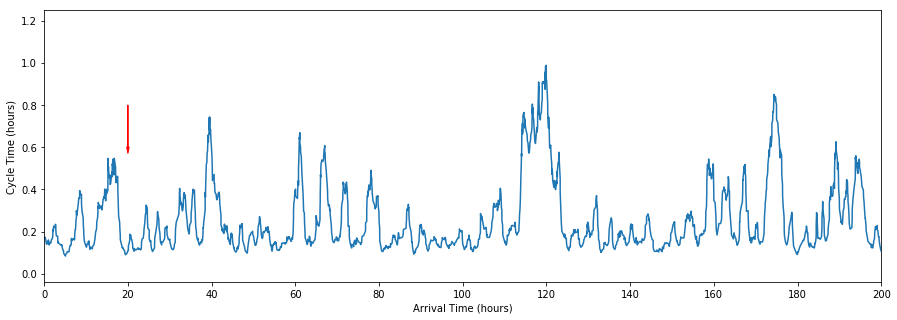

In [7]:
#Plot moving averages

fig=plt.figure(figsize=(15, 5))
plt.plot("ArrivalTime", "MovingAvCycleTime", data=dataSort)
plt.xlim(0, 200)
plt.xlabel("Arrival Time (hours)")
plt.ylabel("Cycle Time (hours)")
plt.arrow(x=20, y=0.8, dx=0, dy=-0.2, width=0.01, head_width=0.6, head_length=0.03, color='r')
plt.xticks(np.arange(0, 220, 20))
plt.savefig("Q1_movingAverageCT.eps")

In [8]:
#Set warm-up time

tw=20

In [9]:
#Find index for t=20
x=[i for i in range(len(data)) if dataSort.loc[i, "ArrivalTime"]>=tw and dataSort.loc[i, "ArrivalTime"]<=2000+tw]

data_crop=dataSort.iloc[x].copy('deep')
data_crop.reset_index(drop=True)

#Compute average CT and epsilon 
averageCycleTime=np.mean(data_crop.loc[:, "CycleTime"])
epsilon=0.005*averageCycleTime


display('Av CT:'+str(averageCycleTime))
display('epsilon: '+str(epsilon))



'Av CT:0.22433007450289402'

'epsilon: 0.00112165037251447'

In [10]:
#Compute standard deviation across 40 hour =2*twsimulations

startTime=tw #data_crop.iloc[0].ArrivalTime
CTaverages_40hr=np.empty((50, 1))

for i in range(50):
    endTime=startTime+40
    startIndex=dataSort[dataSort["ArrivalTime"]>=startTime].index[0]
    endIndex=dataSort[dataSort["ArrivalTime"]>endTime].index[0]-1
    CTaverages_40hr[i]=np.mean(data_crop.loc[startIndex:endIndex].CycleTime)
    startTime=endTime
    


s_40=np.std(CTaverages_40hr, ddof=1)    
display('sd: '+str(np.round(s_40,4)))

'sd: 0.0366'

In [11]:
n=(stats.t.ppf(1-0.005, 49)*s_40/epsilon)**2

display("number of 40 hour simulations: "+str(n))

'number of 40 hour simulations: 7648.30705790678'

--------------------

## Batch means processing ##

In [14]:
dataFull=pd.read_csv('Q1/CycleTimesFull.txt', sep=' ', header=None)
dataFull=dataFull.iloc[:, 1:4].copy('deep')
dataFull.columns=["ArrivalTime", "CallType", "CycleTime"]
dataFull.shape

(9997664, 3)

In [15]:
#Same processing as small dataset
dataFull=dataFull.sort_values("ArrivalTime")
dataFull.reset_index(drop=True)
startIndex=dataFull[dataFull["ArrivalTime"]>=tw].index[0]
dataFull=dataFull.iloc[startIndex:].copy('deep')
dataFull.reset_index(drop=True)
dataFull.head(5)

,ArrivalTime,CallType,CycleTime
212,20.094616,Software,0.057337
213,20.125823,Hardware,0.096950
214,20.166268,Software,0.117031
215,20.329595,Software,0.054002
216,20.464695,Software,0.062710


In [16]:
#Set startTime to last data point from initial analysis

startTime=2000+tw


CTaveragesFull_40hr=np.empty((7649, 1))

for i in range(7649):
    endTime=startTime+40
    startIndex=dataFull[dataFull["ArrivalTime"]>=startTime].index[0]
    endIndex=dataFull[dataFull["ArrivalTime"]>endTime].index[0]-1
    CTaveragesFull_40hr[i]=np.mean(dataFull.loc[startIndex:endIndex].CycleTime)
    startTime=endTime
    


In [24]:
np.savetxt('Q1_CTaveragesFull40.csv', CTaveragesFull_40hr,delimiter=',')

In [23]:
mu_CT=np.mean(CTaveragesFull_40hr)
sd_CT=np.std(CTaveragesFull_40hr, ddof=1)
display('(mean, sd): '+str([mu_CT, sd_CT]))
df=len(CTaveragesFull_40hr)-1
CI_hw=stats.t.ppf(1-0.005, df)*sd_CT/np.sqrt(df+1)
display('CI: '+str([np.round(mu_CT-CI_hw, 3), np.round(mu_CT+CI_hw, 3)]))
display('CI_hw: '+str(np.round(CI_hw/mu_CT, 3)))

'(mean, sd): [0.22287312608727497, 0.03644338601718891]'

'CI: [0.222, 0.224]'

'CI_hw: 0.005'